##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

In [10]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer
from bs4 import BeautifulSoup
import re
import unidecode
from string import punctuation
import contractions
from tabulate import tabulate
import collections

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lingpeng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lingpeng\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lingpeng\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Preprocessing

### Read&Split data 

In [11]:

#Read the CSV datafiles (Train and Test).
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')



Then we separate the tweet text and the label (sentiment). 

In [12]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


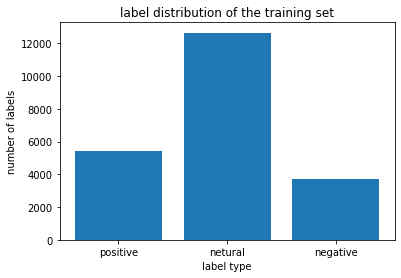

In [13]:

counter = dict(collections.Counter(Y_train))
label = ['positive','netural','negative']
data = [counter['positive'],counter['neutral'],counter['negative']]
plt.bar(label, data)
plt.title('label distribution of the training set')
plt.xlabel('label type')
plt.ylabel('number of labels')
plt.show()

In [14]:
#Split data
X_train,X_valid,y_train,y_valid = train_test_split(X_train_raw,Y_train,test_size=0.28, random_state=30027)

### Preprocessing: Data cleaning

In [15]:
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True) 
ps = nltk.PorterStemmer()
wordnet = nltk.WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
stopwords = []
# exclude words from stopwords list
for i in stop_words:
    if i != 'not' and i != 'no':
        stopwords.append(i)
    

In [75]:
def remove_links(text):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
def remove_email(text):
    return re.sub(r'[\.a-zA-Z0-9_-]*@[\.a-zA-Z0-9_-]*', '', text)
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])

def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
def remove_stopwords(text):
    return ' '.join([wordnet.lemmatize(i) for i in text.split() if i not in stopwords])

def remove_punc(text):
    return ''.join([i.casefold() for i in text if i not in punctuation])

def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

def remove_not_alpha(text):
    return re.sub(r'[^\s\.a-zA-Z0-9_-]+', '', text)

def preprocess(text):
    
#     text = text.replace(r'\n','').replace(r'\m','').replace(r'\r','').replace(r'\t','') 
    no_email = remove_email(text)
    no_accented_chars = remove_accented_chars(no_email)
    no_links = remove_links(no_accented_chars) 
    no_white_space = remove_whitespace(no_links)
    no_punc = remove_punc(no_white_space)  
    no_contractions = expand_contractions(no_punc)
    no_html_tags = strip_html_tags(no_contractions)
    no_num = remove_num(no_html_tags)
    no_stopwords = remove_stopwords(no_num)
    no_alpha = remove_not_alpha(no_stopwords)
    tok = tknzr.tokenize(no_alpha)
    return " ".join([ps.stem(word) for word in tok])

def prepare(text): 
    res = []
    for line in text:
        line = preprocess(line) 
        res.append(line)    
    return res    

#Data cleaning
X_train_clean = prepare(X_train)
X_valid_clean = prepare(X_valid) 


### Preprocessing: Vectorization
**Bag of Words (BoW)**

In this approach, we use the **CountVectorizer** library to separate all the words in the Train corpus (dataset). These words are then used as the 'vectors' or 'features' to represent each instance (Tweet) in `Train` and `Test` datasets. 

In [78]:

BoW_vectorizer_12 = CountVectorizer(ngram_range=(1,2))
#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW_12 = BoW_vectorizer_12.fit_transform(X_train_clean)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_valid_BoW_12 = BoW_vectorizer_12.transform(X_valid_clean)
X_valid_BoW_12.shape


(6105, 127764)

**TFIDF**

In this approach, we use the **TfidfVectorizer** library to separate all the words in this corpus (dataset). Same as the BoW approach, these words are then used as the 'vectors' or 'features' to represent each instance (Tweet).

However, in this method for each instance the value associated with each 'vector' (word) is not the number of times the word repeated in that tweet, but the TFIDF value of then 'voctor' (word).

In [18]:


tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

#Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
X_train_tfidf_12 = tfidf_vectorizer.fit_transform(X_train_clean)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_valid_tfidf_12 = tfidf_vectorizer.transform(X_valid_clean)


### Preprocessing: feature selection 
**select kbest + chi2** 

In [19]:


def chi(k_value):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_12 = selector.fit_transform(X_train_BoW_12 ,y_train)
    x_test_chi_12 = selector.transform(X_valid_BoW_12)

    return x_train_chi_12, x_test_chi_12


**select kbest + f-test** 

In [20]:
def fscore(k_value):
    selector = SelectKBest(f_classif,k=k_value)
    x_train_f_12 = selector.fit_transform(X_train_BoW_12 ,y_train)
    x_test_f_12 = selector.transform(X_valid_BoW_12)

    return x_train_f_12, x_test_f_12


### Compare BoW and TFIDF


In [21]:

def Tfidf_chi(k_value, X_train_tfidf,X_valid_tfidf):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_Tfidf = selector.fit_transform(X_train_tfidf ,y_train)
    x_test_chi_Tfidf = selector.transform(X_valid_tfidf)

    return x_train_chi_Tfidf , x_test_chi_Tfidf
    
def BoW_chi(k_value, X_train_BoW,X_valid_BoW ):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_Bow = selector.fit_transform(X_train_BoW ,y_train)
    x_test_chi_Bow = selector.transform(X_valid_BoW)

    return x_train_chi_Bow, x_test_chi_Bow


In [22]:

def Tfidf_f(k_value, X_train_tfidf,X_valid_tfidf):
    selector = SelectKBest(f_classif,k=k_value)
    x_train_f_Tfidf = selector.fit_transform(X_train_tfidf ,y_train)
    x_test_f_Tfidf = selector.transform(X_valid_tfidf)

    return x_train_f_Tfidf , x_test_f_Tfidf
    
def BoW_f(k_value, X_train_BoW,X_valid_BoW ):
    selector = SelectKBest(f_classif,k=k_value)
    x_train_f_Bow = selector.fit_transform(X_train_BoW ,y_train)
    x_test_f_Bow = selector.transform(X_valid_BoW)

    return x_train_f_Bow, x_test_f_Bow

In [25]:
#TFidf vs BoW
LR_BoW_chi = []
LR_tfidf_chi = []
SVM_BoW_chi = []
SVM_tfidf_chi = []
NB_BoW_chi = []
NB_tfidf_chi = []
RF_BoW_chi = []
RF_tfidf_chi = []
for k in range(200,3000,200):
    x_train_chi_Bow, x_test_chi_Bow = BoW_chi(k, X_train_BoW_12, X_valid_BoW_12)
    x_train_chi_Tfidf , x_test_chi_Tfidf = Tfidf_chi(k, X_train_tfidf_12,X_valid_tfidf_12)
    lr1 = LogisticRegression(max_iter=2000).fit(x_train_chi_Bow, y_train)
    LR1_acc = np.mean(cross_val_score(lr1,x_test_chi_Bow,y_valid,cv = 5))
    LR_BoW_chi.append(LR1_acc)
    lr2 = LogisticRegression(max_iter=2000).fit(x_train_chi_Tfidf, y_train)
    LR2_acc = np.mean(cross_val_score(lr2,x_test_chi_Tfidf,y_valid,cv = 5))
    LR_tfidf_chi.append(LR2_acc)
    clf1 = SVC().fit(x_train_chi_Bow, y_train)
    clf1_acc = np.mean(cross_val_score(clf1,x_test_chi_Bow,y_valid,cv = 5))
    SVM_BoW_chi.append(clf1_acc)
    clf2 = SVC().fit(x_train_chi_Tfidf, y_train)
    clf2_acc = np.mean(cross_val_score(clf2,x_test_chi_Tfidf,y_valid,cv = 5))
    SVM_tfidf_chi.append(clf2_acc)
    nb1 = MultinomialNB().fit(x_train_chi_Bow, y_train)
    nb1_acc = np.mean(cross_val_score(nb1,x_test_chi_Bow,y_valid,cv = 5))
    NB_BoW_chi.append(nb1_acc)
    nb2 = MultinomialNB().fit(x_train_chi_Tfidf, y_train)
    nb2_acc = np.mean(cross_val_score(nb2,x_test_chi_Tfidf,y_valid,cv = 5))
    NB_tfidf_chi.append(nb2_acc)
    rf1 = RandomForestClassifier().fit(x_train_chi_Bow, y_train)
    rf1_acc = np.mean(cross_val_score(rf1,x_test_chi_Bow,y_valid,cv = 5))
    RF_BoW_chi.append(rf1_acc)
    rf2 = RandomForestClassifier().fit(x_train_chi_Tfidf, y_train)
    rf2_acc = np.mean(cross_val_score(rf2,x_test_chi_Tfidf,y_valid,cv = 5))
    RF_tfidf_chi.append(rf2_acc)


In [ ]:
#TFidf vs BoW
LR_BoW_f = []
LR_tfidf_f = []
SVM_BoW_f = []
SVM_tfidf_f = []
NB_BoW_f = []
NB_tfidf_f = []
RF_BoW_f = []
RF_tfidf_f = []
for k in range(100,2000,200):
    x_train_f_Bow, x_test_f_Bow = BoW_f(k, X_train_BoW_12, X_valid_BoW_12)
    x_train_f_Tfidf , x_test_f_Tfidf = Tfidf_f(k, X_train_tfidf_12,X_valid_tfidf_12)
    lr1 = LogisticRegression(max_iter=2000).fit(x_train_f_Bow, y_train)
    LR1_acc = np.mean(cross_val_score(lr1,x_test_f_Bow,y_valid,cv = 5))
    LR_BoW_f.append(LR1_acc)
    lr2 = LogisticRegression(max_iter=2000).fit(x_train_f_Tfidf, y_train)
    LR2_acc = np.mean(cross_val_score(lr2,x_test_f_Tfidf,y_valid,cv = 5))
    LR_tfidf_f.append(LR2_acc)
    clf1 = SVC().fit(x_train_f_Bow, y_train)
    clf1_acc = np.mean(cross_val_score(clf1,x_test_f_Bow,y_valid,cv = 5))
    SVM_BoW_f.append(clf1_acc)
    clf2 = SVC().fit(x_train_f_Tfidf, y_train)
    clf2_acc = np.mean(cross_val_score(clf2,x_test_f_Tfidf,y_valid,cv = 5))
    SVM_tfidf_f.append(clf2_acc)
    nb1 = MultinomialNB().fit(x_train_f_Bow, y_train)
    nb1_acc = np.mean(cross_val_score(nb1,x_test_f_Bow,y_valid,cv = 5))
    NB_BoW_f.append(nb1_acc)
    nb2 = MultinomialNB().fit(x_train_f_Tfidf, y_train)
    nb2_acc = np.mean(cross_val_score(nb2,x_test_f_Tfidf,y_valid,cv = 5))
    NB_tfidf_f.append(nb2_acc)
    rf1 = RandomForestClassifier().fit(x_train_f_Bow, y_train)
    rf1_acc = np.mean(cross_val_score(rf1,x_test_f_Bow,y_valid,cv = 5))
    RF_BoW_f.append(rf1_acc)
    rf2 = RandomForestClassifier().fit(x_train_f_Tfidf, y_train)
    rf2_acc = np.mean(cross_val_score(rf2,x_test_f_Tfidf,y_valid,cv = 5))
    RF_tfidf_f.append(rf2_acc)

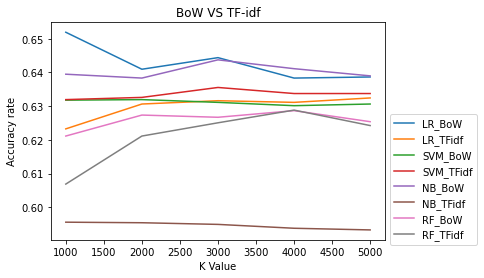

In [215]:
#for chi
x = np.arange(1000,6000,1000)
y1 = np.array(LR_BoW_chi )
y2 = np.array(LR_tfidf_chi)
y3 = np.array(SVM_BoW_chi) 
y4 = np.array(SVM_tfidf_chi)
y5 = np.array(NB_BoW_chi )
y6 = np.array(NB_tfidf_chi)
y7 = np.array(RF_BoW_chi )
y8 = np.array(RF_tfidf_chi)
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4) 
plt.plot(x, y5)
plt.plot(x, y6)
plt.plot(x, y7)
plt.plot(x, y8)

plt.xlabel("K Value") 
plt.ylabel("Accuracy rate") 
plt.title('BoW VS TF-idf')
plt.legend(['LR_BoW','LR_TFidf', 'SVM_BoW', 'SVM_TFidf', 'NB_BoW', 'NB_TFidf','RF_BoW','RF_TFidf'],bbox_to_anchor=(1, 0.60))

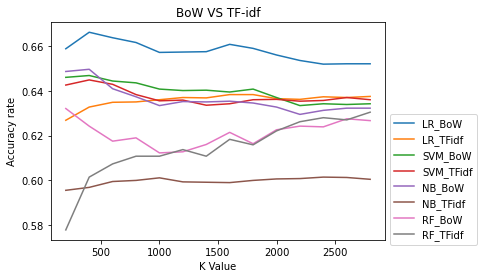

In [203]:
#for f
x = np.arange(200,3000,200)
y1 = np.array(LR_BoW_f )
y2 = np.array(LR_tfidf_f)
y3 = np.array(SVM_BoW_f )
y4 = np.array(SVM_tfidf_f)
y5 = np.array(NB_BoW_f )
y6 = np.array(NB_tfidf_f)
y7 = np.array(RF_BoW_f )
y8 = np.array(RF_tfidf_f)
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4) 
plt.plot(x, y5)
plt.plot(x, y6)
plt.plot(x, y7)
plt.plot(x, y8)

plt.xlabel("K Value") 
plt.ylabel("Accuracy rate") 
plt.title('BoW VS TF-idf')
plt.legend(['LR_BoW','LR_TFidf', 'SVM_BoW', 'SVM_TFidf', 'NB_BoW', 'NB_TFidf','RF_BoW','RF_TFidf'],bbox_to_anchor=(1, 0.60))

**By obsverving the plots, K = 400 and BoW has the best perfermence.**

# Models

### Model: Print results
 

In [43]:
#This function print the result of models
x_train_chi, x_valid_chi = chi(400)
x_train_f, x_valid_f = fscore(400)

def print_result(model, x_train, x_test):
    y_train_predicted = model.predict(x_train)
    ta = np.mean(y_train_predicted == y_train)
    print("training accuracy ", ta)
    va = np.mean(cross_val_score(model,x_test,y_valid,cv = 5))
    print('validation accuracy: ' ,va)
    #y_predicted = model.predict(x_test)
    pa = model.score(x_test, y_valid)
    print('prediction accuracy: ', pa)

    y_pred = model.predict(x_test)
    M_precision = precision_score(y_valid, y_pred, average="macro")
    print('Macro Precision: %f ' % M_precision)
    M_recall = recall_score(y_valid, y_pred, average="macro")
    print('Macro Recall: %f ' % M_recall)
    M_f1 = f1_score(y_valid, y_pred, average="macro")
    print('Macro F1 score: %f ' % M_f1)

    W_precision = precision_score(y_valid, y_pred, average="weighted")
    print('Weighted Precision: %f ' % W_precision)
    W_recall = recall_score(y_valid, y_pred, average="weighted")
    print('Weighted Recall: %f ' % W_recall)
    W_f1 = f1_score(y_valid, y_pred, average="weighted")
    print('Weighted F1 score: %f ' % W_f1)
    cm = confusion_matrix(y_valid, y_pred, labels =model.classes_)
    disp =ConfusionMatrixDisplay(confusion_matrix = cm, display_labels =model.classes_ )
    disp.plot()

    return ta,va,pa,M_precision,M_recall,M_f1,W_precision,W_recall,W_f1

ta_chi = []
va_chi = []
pa_chi = []
M_precision_chi = []
M_recall_chi = []
M_f1_chi = []
W_precision_chi = []
W_recall_chi = []
W_f1_chi = []
time_chi = []

ta_f = []
va_f = []
pa_f = []
M_precision_f = []
M_recall_f = []
M_f1_f = []
W_precision_f = []
W_recall_f = []
W_f1_f = []
time_f = []

### Model: Zero-R

Excution time of Logtistic Regression classifier: 0.003s

training accuracy  0.578964133273874
validation accuracy:  0.5849303849303849
prediction accuracy:  0.584930384930385
Macro Precision: 0.194977 
Macro Recall: 0.333333 
Macro F1 score: 0.246038 
Weighted Precision: 0.342144 
Weighted Recall: 0.584930 
Weighted F1 score: 0.431746 


C:\Users\Lingpeng\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lingpeng\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


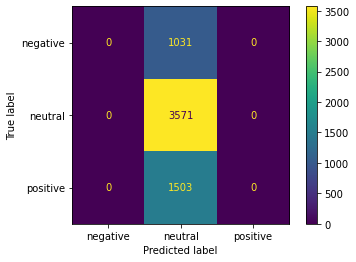

In [44]:
#chi
x_train_chi, x_valid_chi = chi(400)
clf_0R = DummyClassifier(strategy= 'most_frequent')

t0 = time.time()
model_chi = clf_0R.fit(x_train_chi,y_train)
t1 = time.time()-t0
print("Excution time of Logtistic Regression classifier: {}s\n". format(round(t1,3)))

model_chi.score(x_valid_chi,y_valid)
ta_chi_base,va_chi_base,pa_chi_base,M_precision_chi_base,M_recall_chi_base,M_f1_chi_base,W_precision_chi_base,W_recall_chi_base,W_f1_chi_base = print_result(model_chi, x_train_chi,x_valid_chi)
ta_chi.append(ta_chi_base)
va_chi.append(va_chi_base)
pa_chi.append(pa_chi_base)
M_precision_chi.append(M_precision_chi_base)
M_recall_chi.append(M_recall_chi_base)
M_f1_chi.append(M_f1_chi_base)
W_precision_chi.append(W_precision_chi_base)
W_recall_chi.append(W_recall_chi_base)
W_f1_chi.append(W_f1_chi_base)
time_chi.append(t1)

Excution time of Logtistic Regression classifier: 0.005s

training accuracy  0.578964133273874
validation accuracy:  0.5849303849303849
prediction accuracy:  0.584930384930385
Macro Precision: 0.194977 
Macro Recall: 0.333333 
Macro F1 score: 0.246038 
Weighted Precision: 0.342144 
Weighted Recall: 0.584930 
Weighted F1 score: 0.431746 


C:\Users\Lingpeng\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lingpeng\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


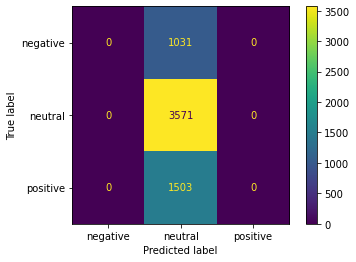

In [45]:
#f
x_train_f, x_valid_f = chi(400)
clf_0R = DummyClassifier(strategy= 'most_frequent')

t0 = time.time()
model_f = clf_0R.fit(x_train_chi,y_train)
t1 = time.time()-t0
print("Excution time of Logtistic Regression classifier: {}s\n". format(round(t1,3)))

model_f.score(x_valid_f,y_valid)
ta_f_base,va_f_base,pa_f_base,M_precision_f_base,M_recall_f_base,M_f1_f_base,W_precision_f_base,W_recall_f_base,W_f1_f_base = print_result(model_f, x_train_f,x_valid_f)
ta_f.append(ta_f_base)
va_f.append(va_f_base)
pa_f.append(pa_f_base)
M_precision_f.append(M_precision_f_base)
M_recall_f.append(M_recall_f_base)
M_f1_f.append(M_f1_f_base)
W_precision_f.append(W_precision_f_base)
W_recall_f.append(W_recall_f_base)
W_f1_f.append(W_f1_f_base)
time_f.append(t1)

### Model: Logistic Regression

In [31]:

#Set K = 400
x_train_chi_LR, x_test_chi_LR = chi(400)

def gs_LogisticRegression(x_train):
    parameters_LR = {'solver':('newton-cg','lbfgs','sag','saga'),'C':np.arange(0.1,2.5,0.2),'multi_class':('auto','ovr','multinomial')}
    LR = LogisticRegression(max_iter=2000)
    gs = GridSearchCV(LR,parameters_LR)
    gs.fit(x_train,y_train)

    return gs.best_estimator_, gs.best_score_


best_estimator_LR, best_score_LR = gs_LogisticRegression(x_train_chi_LR)


In [32]:
print(f"The best estimators are: {best_estimator_LR}")
print(f"The best score is: {best_score_LR}")

The best estimators are: LogisticRegression(C=2.1000000000000005, max_iter=2000, solver='saga')
The best score is: 0.6761804136576418


In [46]:
#C, solver, multi_class, penalty, max_iter
def logistic_regression(k_value, c_value):
    
    x_train_chi_final_LR, x_test_chi_final_LR = chi(k_value)
    #newton-cg's acc is as same as other solvers, e.g. saga
    LR = LogisticRegression(solver= 'saga', C = c_value, max_iter = 2000).fit(x_train_chi_final_LR, y_train)
    y_train_predicted = LR.predict(x_train_chi_final_LR)
    #print("training accuracy ", np.mean(y_train_predicted == y_train))
    LR_acc = np.mean(cross_val_score(LR,x_test_chi_final_LR,y_valid,cv = 5))
    #print('validation accuracy: ' ,LR_acc)
    # y_predicted = LR.predict(x_test_chi)
    #print('prediction accuracy: ',LR.score(x_test_chi_final, y_valid))

    return np.mean(y_train_predicted == y_train), LR_acc, LR.score(x_test_chi_final_LR, y_valid)

#ta_LR, va_LR, pa_LR = logistic_regression(400, 1)

**By observing the plots, K = 400**

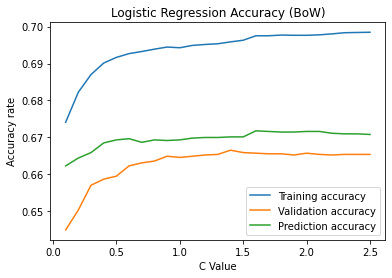

In [36]:
#Accuracy when K = 400
training_accuracy_list_LR = []
validation_accuracy_list_LR = []
prediction_accuracy_list_LR = []


for i in range(1,26,1):
    ta, va, pa = logistic_regression(400, i/10)
    training_accuracy_list_LR.append(ta)
    validation_accuracy_list_LR.append(va)
    prediction_accuracy_list_LR.append(pa)

x = np.arange(0.1,2.6,0.1) 
y1 = np.array(training_accuracy_list_LR)
y2 = np.array(validation_accuracy_list_LR)
y3 = np.array(prediction_accuracy_list_LR)

# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Logistic Regression Accuracy (BoW)") 
# Add Axes Labels and legend
plt.xlabel("C Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

**C = 1.4 => Highest validation accuracy**

**C = 2.1 => Highest prefiction accuracy**

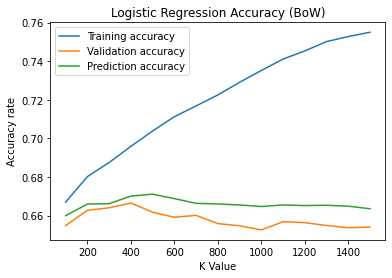

In [37]:
#Accuracy when c = 1.4
training_accuracy_list_LR = []
validation_accuracy_list_LR = []
prediction_accuracy_list_LR = []


for i in range(100,1600,100):
    ta, va, pa = logistic_regression(i,1.4)
    training_accuracy_list_LR.append(ta)
    validation_accuracy_list_LR.append(va)
    prediction_accuracy_list_LR.append(pa)

x = np.arange(100,1600,100) 
y1 = np.array(training_accuracy_list_LR)
y2 = np.array(validation_accuracy_list_LR)
y3 = np.array(prediction_accuracy_list_LR)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Logistic Regression Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("K Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

Excution time of Logtistic Regression classifier: 0.265 s

training accuracy  0.695865451997197
validation accuracy:  0.6665028665028665
prediction accuracy:  0.6701064701064701
Macro Precision: 0.651511 
Macro Recall: 0.540452 
Macro F1 score: 0.568480 
Weighted Precision: 0.665460 
Weighted Recall: 0.670106 
Weighted F1 score: 0.646076 


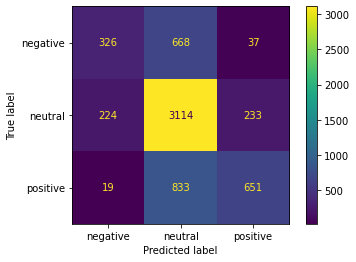

In [47]:
#Finla model: K = 400, c = 1.4
#chi
x_train_chi, x_valid_chi = chi(400)

t0 = time.time()
LR_final_chi = LogisticRegression(solver= 'saga', C = 1.4, max_iter = 2000).fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of Logtistic Regression classifier: {} s\n". format(round(t1,3)))

ta_chi_LR,va_chi_LR,pa_chi_LR,M_precision_chi_LR,M_recall_chi_LR,M_f1_chi_LR,W_precision_chi_LR,W_recall_chi_LR,W_f1_chi_LR = print_result(LR_final_chi, x_train_chi, x_valid_chi)
ta_chi.append(ta_chi_LR)
va_chi.append(va_chi_LR)
pa_chi.append(pa_chi_LR)
M_precision_chi.append(M_precision_chi_LR)
M_recall_chi.append(M_recall_chi_LR)
M_f1_chi.append(M_f1_chi_LR)
W_precision_chi.append(W_precision_chi_LR)
W_recall_chi.append(W_recall_chi_LR)
W_f1_chi.append(W_f1_chi_LR)
time_chi.append(t1)

Excution time of Logtistic Regression classifier: 0.275s

training accuracy  0.6982862967446009
validation accuracy:  0.6663390663390663
prediction accuracy:  0.6710892710892711
Macro Precision: 0.652429 
Macro Recall: 0.544082 
Macro F1 score: 0.572214 
Weighted Precision: 0.666459 
Weighted Recall: 0.671089 
Weighted F1 score: 0.648128 


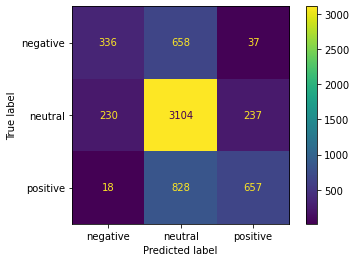

In [48]:
#fscore
x_train_f, x_valid_f = fscore(400)

t0 = time.time()
LR_final_f = LogisticRegression(solver= 'saga', C = 1.4, max_iter = 2000).fit(x_train_f, y_train)
t1 = time.time()-t0
print("Excution time of Logtistic Regression classifier: {}s\n". format(round(t1,3)))

ta_f_LR,va_f_LR,pa_f_LR,M_precision_f_LR,M_recall_f_LR,M_f1_f_LR,W_precision_f_LR,W_recall_f_LR,W_f1_f_LR = print_result(LR_final_f, x_train_f, x_valid_f)
ta_f.append(ta_f_LR)
va_f.append(va_f_LR)
pa_f.append(pa_f_LR)
M_precision_f.append(M_precision_f_LR)
M_recall_f.append(M_recall_f_LR)
M_f1_f.append(M_f1_f_LR)
W_precision_f.append(W_precision_f_LR)
W_recall_f.append(W_recall_f_LR)
W_f1_f.append(W_f1_f_LR)
time_f.append(t1)

### Model: SVM



In [ ]:
parameters_svc = {"kernel":('linear', 'poly', 'rbf', 'sigmoid'), "decision_function_shape":('ovo','ovr'), 'C':np.arange(0.1,2.5,0.3)}
gs_svc = GridSearchCV(SVC(), param_grid = parameters_svc)  
gs_svc.fit(x_train_chi, y_train)

In [31]:
print(gs_svc.best_params_)

{'C': 1.0000000000000002, 'gamma': 1e-06, 'kernel': 'linear'}


In [49]:
#C, kernel, degree, gamma, max_iter, decision_function_shape
def svc(c_value):
    clf = SVC(kernel="linear", C = c_value, decision_function_shape = 'ovo').fit(x_train_chi, y_train)
    y_train_predicted = clf.predict(x_train_chi)
    #print("training accuracy ", np.mean(y_train_predicted == y_train))
    clf_va = np.mean(cross_val_score(clf,x_valid_chi,y_valid,cv = 5))
    #print('validation accuracy: ' ,clf_va)
    # y_predicted = LR.predict(x_test_chi)
    #print('prediction accuracy: ',clf.score(x_test_chi_SVM, y_valid))

    return np.mean(y_train_predicted == y_train), clf_va, clf.score(x_valid_chi, y_valid)

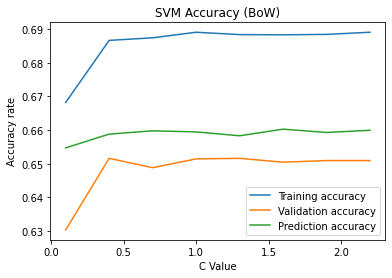

In [42]:
#Accuracy when K = 400
training_accuracy_list_SVM = []
validation_accuracy_list_SVM = []
prediction_accuracy_list_SVM = []


for i in range(1,25,3):
    ta, va, pa = svc(i/10)
    training_accuracy_list_SVM.append(ta)
    validation_accuracy_list_SVM.append(va)
    prediction_accuracy_list_SVM.append(pa)

x = np.arange(0.1,2.5,0.3) 
y1 = np.array(training_accuracy_list_SVM)
y2 = np.array(validation_accuracy_list_SVM)
y3 = np.array(prediction_accuracy_list_SVM)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("SVM Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("C Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

Highest va: c =0.4

Highest pa: c =1.7

Excution time of SVM classifier: 5.633 s
training accuracy  0.6866917245333504
validation accuracy:  0.6515970515970517
prediction accuracy:  0.6588042588042589
Macro Precision: 0.627407 
Macro Recall: 0.523475 
Macro F1 score: 0.548211 
Weighted Precision: 0.649630 
Weighted Recall: 0.658804 
Weighted F1 score: 0.632546 


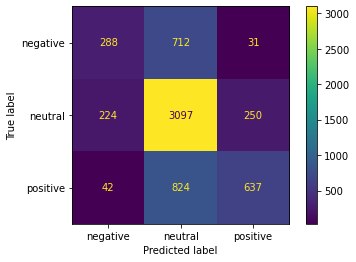

In [50]:
#chi
x_train_chi, x_valid_chi = chi(400)

t0 = time.time()
SVM_final_chi = SVC(kernel="linear", C = 0.4, decision_function_shape = 'ovo').fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of SVM classifier: {} s". format(round(t1,3)))

ta_chi_SVM,va_chi_SVM,pa_chi_SVM,M_precision_chi_SVM,M_recall_chi_SVM,M_f1_chi_SVM,W_precision_chi_SVM,W_recall_chi_SVM,W_f1_chi_SVM = print_result(SVM_final_chi, x_train_chi, x_valid_chi)
ta_chi.append(ta_chi_SVM)
va_chi.append(va_chi_SVM)
pa_chi.append(pa_chi_SVM)
M_precision_chi.append(M_precision_chi_SVM)
M_recall_chi.append(M_recall_chi_SVM)
M_f1_chi.append(M_f1_chi_SVM)
W_precision_chi.append(W_precision_chi_SVM)
W_recall_chi.append(W_recall_chi_SVM)
W_f1_chi.append(W_f1_chi_SVM)
time_chi.append(t1)

Excution time of SVM classifier: 5.505 s
training accuracy  0.6876473211441677
validation accuracy:  0.6515970515970517
prediction accuracy:  0.6565110565110565
Macro Precision: 0.622619 
Macro Recall: 0.522959 
Macro F1 score: 0.547180 
Weighted Precision: 0.646399 
Weighted Recall: 0.656511 
Weighted F1 score: 0.630968 


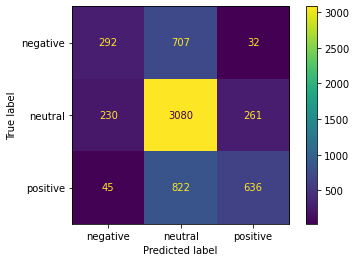

In [51]:
#f-score
x_train_f, x_valid_f = fscore(400)

t0 = time.time()
SVM_final_f = SVC(kernel="linear", C = 0.4, decision_function_shape = 'ovo').fit(x_train_f, y_train)
t1 = time.time()-t0

print("Excution time of SVM classifier: {} s". format(round(t1,3)))
ta_f_SVM,va_f_SVM,pa_f_SVM,M_precision_f_SVM,M_recall_f_SVM,M_f1_f_SVM,W_precision_f_SVM,W_recall_f_SVM,W_f1_f_SVM = print_result(SVM_final_f, x_train_f, x_valid_f)
ta_f.append(ta_f_SVM)
va_f.append(va_f_SVM)
pa_f.append(pa_f_SVM)
M_precision_f.append(M_precision_f_SVM)
M_recall_f.append(M_recall_f_SVM)
M_f1_f.append(M_f1_f_SVM)
W_precision_f.append(W_precision_f_SVM)
W_recall_f.append(W_recall_f_SVM)
W_f1_f.append(W_f1_f_SVM)
time_f.append(t1)

### Model: Multi-nominal Naive Bayes

In [189]:
parameters_MNB = {"alpha":( np.arange(0.0001,1,0.01))}
gs_MNB = GridSearchCV(MultinomialNB(), param_grid = parameters_MNB)  
gs_MNB.fit(x_train_chi, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': array([1.000e-04, 1.010e-02, 2.010e-02, 3.010e-02, 4.010e-02, 5.010e-02,
       6.010e-02, 7.010e-02, 8.010e-02, 9.010e-02, 1.001e-01, 1.101e-01,
       1.201e-01, 1.301e-01, 1.401e-01, 1.501e-01, 1.601e-01, 1.701e-01,
       1.801e-01, 1.901e-01, 2.001e-01, 2.101e-01, 2.201e-01, 2.301e-01,
       2.401e-01, 2.501e-01, 2.601e-01, 2.701e-01, 2.80...
       6.001e-01, 6.101e-01, 6.201e-01, 6.301e-01, 6.401e-01, 6.501e-01,
       6.601e-01, 6.701e-01, 6.801e-01, 6.901e-01, 7.001e-01, 7.101e-01,
       7.201e-01, 7.301e-01, 7.401e-01, 7.501e-01, 7.601e-01, 7.701e-01,
       7.801e-01, 7.901e-01, 8.001e-01, 8.101e-01, 8.201e-01, 8.301e-01,
       8.401e-01, 8.501e-01, 8.601e-01, 8.701e-01, 8.801e-01, 8.901e-01,
       9.001e-01, 9.101e-01, 9.201e-01, 9.301e-01, 9.401e-01, 9.501e-01,
       9.601e-01, 9.701e-01, 9.801e-01, 9.901e-01])})

In [190]:
gs_MNB.best_estimator_

MultinomialNB(alpha=0.7501)

Excution time of Multi-nominal Naive Bayes classifier: 0.014 s
training accuracy  0.67235777537109
validation accuracy:  0.6465192465192466
prediction accuracy:  0.6515970515970516
Macro Precision: 0.612864 
Macro Recall: 0.562455 
Macro F1 score: 0.579800 
Weighted Precision: 0.644554 
Weighted Recall: 0.651597 
Weighted F1 score: 0.641032 


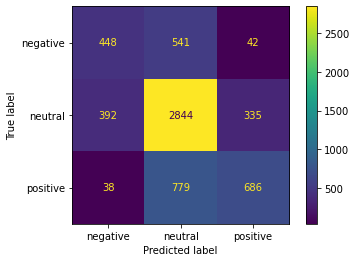

In [52]:
x_train_chi, x_valid_chi = chi(400)

t0 = time.time()
MNB_final_chi = MultinomialNB(alpha = 0.75).fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of Multi-nominal Naive Bayes classifier: {} s". format(round(t1,3)))

ta_chi_MNB,va_chi_MNB,pa_chi_MNB,M_precision_chi_MNB,M_recall_chi_MNB,M_f1_chi_MNB,W_precision_chi_MNB,W_recall_chi_MNB,W_f1_chi_MNB = print_result(MNB_final_chi, x_train_chi, x_valid_chi)
ta_chi.append(ta_chi_MNB)
va_chi.append(va_chi_MNB)
pa_chi.append(pa_chi_MNB)
M_precision_chi.append(M_precision_chi_MNB)
M_recall_chi.append(M_recall_chi_MNB)
M_f1_chi.append(M_f1_chi_MNB)
W_precision_chi.append(W_precision_chi_MNB)
W_recall_chi.append(W_recall_chi_MNB)
W_f1_chi.append(W_f1_chi_MNB)
time_chi.append(t1)

Excution time of Multi-nominal Naive Bayes classifier: 0.011 s
training accuracy  0.6736319041855131
validation accuracy:  0.6465192465192464
prediction accuracy:  0.650941850941851
Macro Precision: 0.611894 
Macro Recall: 0.564414 
Macro F1 score: 0.581032 
Weighted Precision: 0.644376 
Weighted Recall: 0.650942 
Weighted F1 score: 0.641254 


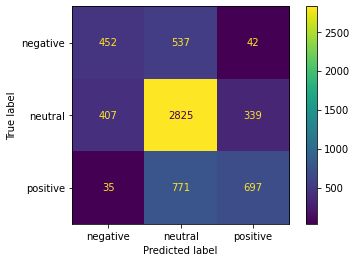

In [53]:
x_train_f, x_valid_f = fscore(400)

t0 = time.time()
MNB_final_f = MultinomialNB(alpha = 0.0251).fit(x_train_f, y_train)
t1 = time.time()-t0
print("Excution time of Multi-nominal Naive Bayes classifier: {} s". format(round(t1,3)))

ta_f_MNB,va_f_MNB,pa_f_MNB,M_precision_f_MNB,M_recall_f_MNB,M_f1_f_MNB,W_precision_f_MNB,W_recall_f_MNB,W_f1_f_MNB = print_result(MNB_final_f, x_train_f, x_valid_f)
ta_f.append(ta_f_MNB)
va_f.append(va_f_MNB)
pa_f.append(pa_f_MNB)
M_precision_f.append(M_precision_f_MNB)
M_recall_f.append(M_recall_f_MNB)
M_f1_f.append(M_f1_f_MNB)
W_precision_f.append(W_precision_f_MNB)
W_recall_f.append(W_recall_f_MNB)
W_f1_f.append(W_f1_f_MNB)
time_f.append(t1)

### Model: Random Forest

In [ ]:
x_train_chi_RF, x_test_chi_RF = chi(400)
parameters_RF = {"n_estimators":[100,200,250,300,350,400], "criterion": ('gini', 'entropy'), "max_depth":[40,50,60,70], "min_samples_split":[2,3,4,5,6], "min_samples_leaf":[1,2,3,4,5]}
gs_RF = GridSearchCV(RandomForestClassifier(), param_grid = parameters_RF)  
gs_RF.fit(x_train_chi_RF, y_train)

In [108]:
gs_RF.best_estimator_

RandomForestClassifier(max_depth=70, min_samples_leaf=3, n_estimators=300)

Excution time of Random Forest classifier: 3.073 s
training accuracy  0.6994330126775817
validation accuracy:  0.6501228501228502
prediction accuracy:  0.6571662571662572
Macro Precision: 0.642269 
Macro Recall: 0.500452 
Macro F1 score: 0.521591 
Weighted Precision: 0.651610 
Weighted Recall: 0.657166 
Weighted F1 score: 0.619160 


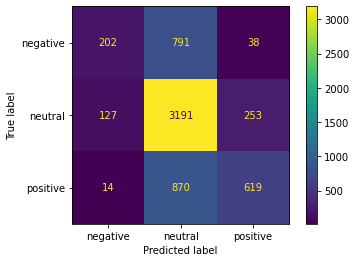

In [54]:
x_train_chi, x_valid_chi = chi(400)

t0 = time.time()
RF_final_chi = RandomForestClassifier(max_depth=70, min_samples_leaf=2, n_estimators=350).fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of Random Forest classifier: {} s". format(round(t1,3)))

ta_chi_RF,va_chi_RF,pa_chi_RF,M_precision_chi_RF,M_recall_chi_RF,M_f1_chi_RF,W_precision_chi_RF,W_recall_chi_RF,W_f1_chi_RF = print_result(RF_final_chi, x_train_chi, x_valid_chi)
ta_chi.append(ta_chi_RF)
va_chi.append(va_chi_RF)
pa_chi.append(pa_chi_RF)
M_precision_chi.append(M_precision_chi_RF)
M_recall_chi.append(M_recall_chi_RF)
M_f1_chi.append(M_f1_chi_RF)
W_precision_chi.append(W_precision_chi_RF)
W_recall_chi.append(W_recall_chi_RF)
W_f1_chi.append(W_f1_chi_RF)
time_chi.append(t1)


In [ ]:

"""
max_depth=70, min_samples_leaf=4, n_estimators=300
    Excution time of Random Forest classifier: 1.767 s
    training accuracy  0.6745237943556094
    validation accuracy:  0.6461916461916462
    prediction accuracy:  0.6538902538902539
    Macro Precision: 0.639694 
    Macro Recall: 0.490820 
    Macro F1 score: 0.507381 
    Weighted Precision: 0.648067 
    Weighted Recall: 0.653890 
    Weighted F1 score: 0.611430 

max_depth=70, min_samples_leaf=3, n_estimators=300
    Excution time of Random Forest classifier: 2.104 s
    training accuracy  0.6813403835127732
    validation accuracy:  0.6484848484848484
    prediction accuracy:  0.6543816543816544
    Macro Precision: 0.640519 
    Macro Recall: 0.492805 
    Macro F1 score: 0.511207 
    Weighted Precision: 0.648942 
    Weighted Recall: 0.654382 
    Weighted F1 score: 0.613146 


max_depth=70, min_samples_leaf=2, n_estimators=300
    Excution time of Random Forest classifier: 2.52 s
    training accuracy  0.6986048289482066
    validation accuracy:  0.6497952497952497
    prediction accuracy:  0.657985257985258
    Macro Precision: 0.643680 
    Macro Recall: 0.501230 
    Macro F1 score: 0.522314 
    Weighted Precision: 0.652686 
    Weighted Recall: 0.657985 
    Weighted F1 score: 0.619964 


max_depth=70, min_samples_leaf=1, n_estimators=300
    Excution time of Random Forest classifier: 7.271 s
    training accuracy  0.7997069503726827
    validation accuracy:  0.6348894348894347
    prediction accuracy:  0.6494676494676495
    Macro Precision: 0.635230 
    Macro Recall: 0.484273 
    Macro F1 score: 0.502493 
    Weighted Precision: 0.644150 
    Weighted Recall: 0.649468 
    Weighted F1 score: 0.606006 

Hence, min_samples_leaf=2

max_depth=70, min_samples_leaf=2, n_estimators=350
    Excution time of Random Forest classifier: 2.856 s
    training accuracy  0.6982862967446009
    validation accuracy:  0.6519246519246519
    prediction accuracy:  0.6553644553644553
    Macro Precision: 0.636809 
    Macro Recall: 0.496800 
    Macro F1 score: 0.515843 
    Weighted Precision: 0.648088 
    Weighted Recall: 0.655364 
    Weighted F1 score: 0.616045 


max_depth=70, min_samples_leaf=2, n_estimators=400
    Excution time of Random Forest classifier: 3.248 s
    training accuracy  0.698350003185322
    validation accuracy:  0.6501228501228501
    prediction accuracy:  0.6561834561834562
    Macro Precision: 0.639291 
    Macro Recall: 0.499101 
    Macro F1 score: 0.519646 
    Weighted Precision: 0.649754 
    Weighted Recall: 0.656183 
    Weighted F1 score: 0.617913 

Hnece, n_estimators=350

max_depth=75, min_samples_leaf=2, n_estimators=350
    training accuracy  0.7020449767471492
    validation accuracy:  0.6507780507780507
    prediction accuracy:  0.6565110565110565
    Macro Precision: 0.638065 
    Macro Recall: 0.501160 
    Macro F1 score: 0.521790 
    Weighted Precision: 0.649388 
    Weighted Recall: 0.656511 
    Weighted F1 score: 0.619198 


max_depth=65, min_samples_leaf=2, n_estimators=350
    training accuracy  0.6960565713193604
    validation accuracy:  0.6486486486486487
    prediction accuracy:  0.6553644553644553
    Macro Precision: 0.639571 
    Macro Recall: 0.495767 
    Macro F1 score: 0.515601 
    Weighted Precision: 0.649458 
    Weighted Recall: 0.655364 
    Weighted F1 score: 0.615595 

final: max_depth=70, min_samples_leaf=2, n_estimators=350
"""


Excution time of Random Forest classifier: 2.969 s
training accuracy  0.6987959482703702
validation accuracy:  0.6511056511056511
prediction accuracy:  0.6573300573300573
Macro Precision: 0.641019 
Macro Recall: 0.500038 
Macro F1 score: 0.520576 
Weighted Precision: 0.651139 
Weighted Recall: 0.657330 
Weighted F1 score: 0.618986 


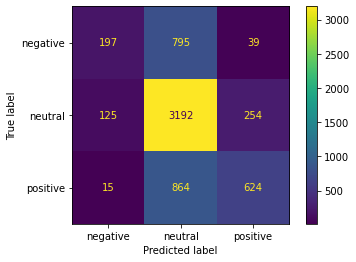

In [55]:
#fscore
x_train_f, x_valid_f = fscore(400)

t0 = time.time()
RF_final_f = RandomForestClassifier(max_depth=70, min_samples_leaf=2, n_estimators=350).fit(x_train_f, y_train)
t1 = time.time()-t0
print("Excution time of Random Forest classifier: {} s". format(round(t1,3)))

ta_f_RF,va_f_RF,pa_f_RF,M_precision_f_RF,M_recall_f_RF,M_f1_f_RF,W_precision_f_RF,W_recall_f_RF,W_f1_f_RF = print_result(RF_final_f, x_train_f, x_valid_f)
ta_f.append(ta_f_RF)
va_f.append(va_f_RF)
pa_f.append(pa_f_RF)
M_precision_f.append(M_precision_f_RF)
M_recall_f.append(M_recall_f_RF)
M_f1_f.append(M_f1_f_RF)
W_precision_f.append(W_precision_f_RF)
W_recall_f.append(W_recall_f_RF)
W_f1_f.append(W_f1_f_RF)
time_f.append(t1)

### Model: Stacking

In [56]:
x_train_chi, x_valid_chi = chi(400)

estimator = [('lr', LogisticRegression(solver= 'saga', C = 1.4, max_iter = 2000)),
            ('svc', SVC(kernel="linear", C = 0.4,decision_function_shape = 'ovo')),
            ('RF', RandomForestClassifier(max_depth=70, min_samples_leaf=2, n_estimators=350))
            ]
clf2 = StackingClassifier(estimators= estimator, final_estimator=LogisticRegression(max_iter=2000))


Excution time of Stacking classifier: 44.353 s
training accuracy  0.7031916926801299
validation accuracy:  0.6661752661752661
prediction accuracy:  0.6732186732186732
Macro Precision: 0.657268 
Macro Recall: 0.545457 
Macro F1 score: 0.574220 
Weighted Precision: 0.669455 
Weighted Recall: 0.673219 
Weighted F1 score: 0.650093 


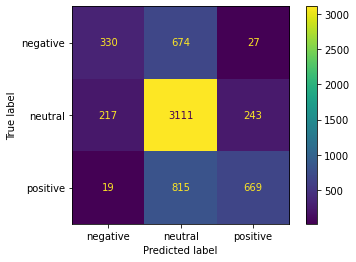

In [57]:
t0 = time.time()
S_final_chi = clf2.fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of Stacking classifier: {} s". format(round(t1,3)))

ta_chi_S,va_chi_S,pa_chi_S,M_precision_chi_S,M_recall_chi_S,M_f1_chi_S,W_precision_chi_S,W_recall_chi_S,W_f1_chi_S = print_result(S_final_chi, x_train_chi, x_valid_chi)
ta_chi.append(ta_chi_S)
va_chi.append(va_chi_S)
pa_chi.append(pa_chi_S)
M_precision_chi.append(M_precision_chi_S)
M_recall_chi.append(M_recall_chi_S)
M_f1_chi.append(M_f1_chi_S)
W_precision_chi.append(W_precision_chi_S)
W_recall_chi.append(W_recall_chi_S)
W_f1_chi.append(W_f1_chi_S)
time_chi.append(t1)

Excution time of Stacking classifier: 54.243 s
training accuracy  0.7026183347136395
validation accuracy:  0.6669942669942671
prediction accuracy:  0.6723996723996724
Macro Precision: 0.656538 
Macro Recall: 0.545857 
Macro F1 score: 0.574629 
Weighted Precision: 0.668726 
Weighted Recall: 0.672400 
Weighted F1 score: 0.649657 


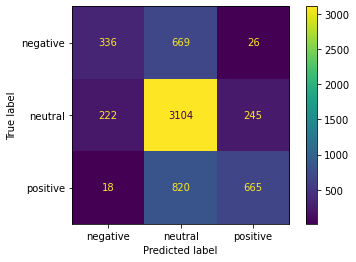

In [58]:
x_train_f, x_valid_f = fscore(400)

t0 = time.time()
S_final_f = clf2.fit(x_train_f, y_train)
t1 = time.time()-t0
print("Excution time of Stacking classifier: {} s". format(round(t1,3)))

ta_f_S,va_f_S,pa_f_S,M_precision_f_S,M_recall_f_S,M_f1_f_S,W_precision_f_S,W_recall_f_S,W_f1_f_S = print_result(S_final_f, x_train_f, x_valid_f)
ta_f.append(ta_f_S)
va_f.append(va_f_S)
pa_f.append(pa_f_S)
M_precision_f.append(M_precision_f_S)
M_recall_f.append(M_recall_f_S)
M_f1_f.append(M_f1_f_S)
W_precision_f.append(W_precision_f_S)
W_recall_f.append(W_recall_f_S)
W_f1_f.append(W_f1_f_S)
time_f.append(t1)

In [60]:
#lr, svm, mnb, rf, s
chi_list = []
chi_columns = []
chi_index = []
chi_list.append(ta_chi)
chi_list.append(va_chi)
chi_list.append(pa_chi)
chi_list.append(M_precision_chi)
chi_list.append(M_recall_chi)
chi_list.append(M_f1_chi)
chi_list.append(W_precision_chi)
chi_list.append(W_recall_chi)
chi_list.append(W_f1_chi)
chi_list.append(time_chi)
chi_columns = ['Base-line','Logistic Regression', 'SVM', 'MNB','Random Forest', 'Staking']
chi_index = ['Training Accuracy', 'Validation Accuray', 'Prediction Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-score', 
'Weighted Precision', 'Weighted Recall', 'Weighted F1-score', 'Execute time']
chi_np_list = np.array(chi_list)
chi_df = pd.DataFrame(chi_np_list,columns=chi_columns, index = chi_index)

f_list = []
f_columns = []
f_index = []
f_list.append(ta_f)
f_list.append(va_f)
f_list.append(pa_f)
f_list.append(M_precision_f)
f_list.append(M_recall_f)
f_list.append(M_f1_f)
f_list.append(W_precision_f)
f_list.append(W_recall_f)
f_list.append(W_f1_f)
f_list.append(time_f)
f_columns = ['Base-line','Logistic Regression', 'SVM', 'MNB','Random Forest', 'Staking']
f_index = ['Training Accuracy', 'Validation Accuray', 'Prediction Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-score', 
'Weighted Precision', 'Weighted Recall', 'Weighted F1-score', 'Execute time']
f_np_list = np.array(f_list)
f_df = pd.DataFrame(f_np_list,columns=f_columns, index=f_index)


In [61]:
print("Chi2")
display(chi_df)
print('Fscore')
display(f_df)

Chi2


,Base-line,Logistic Regression,SVM,MNB,Random Forest,Staking
Training Accuracy,0.578964,0.695865,0.686692,0.672358,0.699433,0.703192
Validation Accuray,0.584930,0.666503,0.651597,0.646519,0.650123,0.666175
Prediction Accuracy,0.584930,0.670106,0.658804,0.651597,0.657166,0.673219
Macro Precision,0.194977,0.651511,0.627407,0.612864,0.642269,0.657268
Macro Recall,0.333333,0.540452,0.523475,0.562455,0.500452,0.545457
Macro F1-score,0.246038,0.568480,0.548211,0.579800,0.521591,0.574220
Weighted Precision,0.342144,0.665460,0.649630,0.644554,0.651610,0.669455
Weighted Recall,0.584930,0.670106,0.658804,0.651597,0.657166,0.673219
Weighted F1-score,0.431746,0.646076,0.632546,0.641032,0.619160,0.650093
Execute time,0.002999,0.264592,5.633196,0.013554,3.073300,44.353401


Fscore


,Base-line,Logistic Regression,SVM,MNB,Random Forest,Staking
Training Accuracy,0.578964,0.698286,0.687647,0.673632,0.698796,0.702618
Validation Accuray,0.584930,0.666339,0.651597,0.646519,0.651106,0.666994
Prediction Accuracy,0.584930,0.671089,0.656511,0.650942,0.657330,0.672400
Macro Precision,0.194977,0.652429,0.622619,0.611894,0.641019,0.656538
Macro Recall,0.333333,0.544082,0.522959,0.564414,0.500038,0.545857
Macro F1-score,0.246038,0.572214,0.547180,0.581032,0.520576,0.574629
Weighted Precision,0.342144,0.666459,0.646399,0.644376,0.651139,0.668726
Weighted Recall,0.584930,0.671089,0.656511,0.650942,0.657330,0.672400
Weighted F1-score,0.431746,0.648128,0.630968,0.641254,0.618986,0.649657
Execute time,0.005027,0.275307,5.504724,0.011240,2.968959,54.242893


### Final Prediction

In [84]:
#preprocessing
test_data = pd.read_csv("Test.csv", sep=',')
test = test_data['text']
x_test = prepare(test)



In [85]:
X_test_BoW_12 = BoW_vectorizer_12.transform(x_test)

selector = SelectKBest(chi2,k=400)
x_train_chi_12 = selector.fit_transform(X_train_BoW_12 ,y_train)

x_test_12 = selector.transform(X_test_BoW_12)

In [88]:
y_predicted = LR_final_chi.predict(x_test_12)
l = pd.DataFrame(y_predicted, columns= ['sentiment'])
result = pd.concat([test_data["id"],l], axis = 1)
result.to_csv("prediction1.csv", index = None)
